<a href="https://colab.research.google.com/github/chriscandido/GEE/blob/main/Land_cover_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import math
import folium
import subprocess
import numpy as np
import pandas as pd

from folium import plugins
from IPython.display import Image

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

try:
    import ipygee
except ImportError:
    print('Installing ipygee ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'ipygee'])

import geemap 
import geemap.eefolium as geemap
from ipygee import *

In [2]:
# Google Earth Engine Authentication
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=6NFkc-MPiNMOnZsO03m805kySB25vGQ5RWPjMjzMCu4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhcGFeOKuYf2dexK4e1JdPpRMQCIVkpRPWIxKhHENnF2HXWN_vmTE8

Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
AOI = ee.Geometry.Polygon([[[120, 15.30],
                            [120, 14],
                            [121.35, 14],
                            [121.35, 15.30]]])
Point_1 = ee.FeatureCollection(
    [ee.Feature(
        ee.Geometry.Point([120.675, 14.65]),
        {
              "system:index": "0"
            })]);
watershed = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed').geometry() 
boundary = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed_boundary').geometry() 

**Basemap**

In [5]:
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [6]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

**Global Variables**

In [7]:
#Global Variables
#Landsat 8 Bands
opticalBandL8 = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
thermalBandL8 = ['SR_B10']
bandL8 = opticalBandL8 + thermalBandL8

#Landsat 5 Bands
opticalBandL5 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBandL5 = ['B6']
bandL5 = opticalBandL5 + thermalBandL5

#Harmonic Model Variables
dependent = 'EVI'
harmonics = 2
harmonicFrequencies = list(range(1, harmonics+1))

def getNames (base, lst_freq) :
    name_lst = []
    for i in lst_freq:
        name_lst.append(ee.String(base + str(i)))
    return name_lst

cosNames = getNames('cos_', harmonicFrequencies);
sinNames = getNames('sin_', harmonicFrequencies);
independents = ee.List(['constant','t']).cat(cosNames).cat(sinNames);

## **Satellite Image Pre-processing**

*   *Satellite Imagery Access*
*   *Cloud and Cloud-shadow Masking*
*   *Harmonic Regression Modelling*

### **Cloud and Cloud-shadow Masking Landsat Satellite Image**

**Landsat 8**

In [8]:
#Function to cloud mask from the pixel_qa band of Landsat 8 data
def mask(image):
    #Bits 3 and 4 are cloud and cloud shaadow respectively
    cloudBitMask = 1 << 3
    cloudShadowBitMask = 1 << 4
    
    #Get QA Pixel Band
    qa = image.select('QA_PIXEL')
    
    #Flag set to zero which indicated clear conditions
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudBitMask).eq(0))
 
    #Return the masked image, scaled reflectance, without QA bands
    return image.updateMask(mask).divide(27500).select(opticalBandL8).copyProperties(image, ["system:time_start"])

**Landsat 5**

In [9]:
def maskL5(image):
    qa = image.select('pixel_qa');
    #If the cloud bit (5) is set and the cloud confidence (7) is high
    #or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    
    #Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min());
    
    return image.updateMask(cloud.Not()).updateMask(mask2).divide(10000).select(opticalBandL5).copyProperties(image, ["system:time_start"])

### **Harmonic Regression**

In [10]:
def addConstant(image):
    return image.addBands(ee.Image(1));

def addTime(image):
    date = ee.Date(image.get('system:time_start'));
    years = date.difference(ee.Date('1970-01-01'), 'year');
    timeRadians = ee.Image(years.multiply(2*math.pi));
    return image.addBands(timeRadians.rename('t').float());

def addHarmonics(image):
    frequencies = ee.Image.constant(harmonicFrequencies)
    time = ee.Image(image).select('t')
    cosines = time.multiply(frequencies).cos().rename(cosNames)
    sines = time.multiply(frequencies).sin().rename(sinNames)
    return image.addBands(cosines).addBands(sines);

In [11]:
#Landsat 8 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_EVI') #USGS Landsat 8 Level 2, Collection 2, Tier 1
eviLandsat8 = collection.filterDate('2019-01-01', '2020-12-31').filterBounds(boundary).select('EVI')

#Harmonic
harmonicLandsat = eviLandsat8.map(addConstant).map(addTime).map(addHarmonics)

In [ ]:
#Landsat 5 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') #USGS Landsat 5 Level 2, Collection 2, Tier 1
eviLandsat5 = collection.filterDate('2010-01-01', '2011-12-31').filterBounds(boundary).map(maskL5).map(addTasseledCap)

#Harmonic
harmonicLandsat5 = eviLandsat5.map(addConstant).map(addTime).map(addHarmonics)

NameError: ignored

In [12]:
# Compute a linear trend.  This will have two bands: 'residuals' and 
# a 2x1 band called coefficients (columns are for dependent variables).
harmonicTrend = harmonicLandsat.select(independents.add(dependent))\
                                .reduce(ee.Reducer.linearRegression(independents.length(),1))

# Flatten the coefficients into a 2-band image|
harmonicTrendCoefficients = harmonicTrend.select('coefficients').arrayProject([0]).arrayFlatten([independents])

#Compute fitted values 
fittedHarmonic = harmonicLandsat.map(lambda image : image\
                                    .addBands(image.select(independents)\
                                    .multiply(harmonicTrendCoefficients)\
                                    .reduce('sum')\
                                    .rename('fitted')));

In [13]:
#Annual Crop
annualCrop = ee.FeatureCollection('users/cgcandido/validation').filter(ee.Filter.eq('lc3', 'annualCrop')) 
MD_ndvi = chart.Image.series(**{'imageCollection': fittedHarmonic,  'region': annualCrop,
'reducer': ee.Reducer.mean(),
'bands' : ['fitted', 'EVI'],
'scale': 500,
'xProperty': 'system:time_start'})
MD_ndvi.renderWidget(width='100%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

## **Dataset Preparation**

<b>1. Harmonic Modelling Features</b>
<br>
<blockquote>
    1.1. Mean, Median, Max, Min, and Std Dev Enhanced Vegetation Index (EVI)<br>
    1.2. Phase<br>
    1.3. Amplitude
</blockquote>
<br>
<b>2. Seasonal Composite</b>
<blockquote>
    1.1. Spectral Bands<br>
    1.2. Normalized Difference Water Index (NDWI)<br>
    1.3. Normalized Difference Built-up Index (NDBI)
</blockquote>
<br>
<b>2. Othe Features</b>
<blockquote>
    1.1. Nightime Lights<br>
    1.2. Topographic Features (DEM, Slope)<br>
</blockquote>

### **Harmonic Modelling Features**

In [14]:
#Compute phase, amplitude, and mean EVI
phase = harmonicTrendCoefficients.select('sin_1')\
                                    .atan2(harmonicTrendCoefficients.select('cos_1'))\
                                    .unitScale(-math.pi, math.pi)\
                                    .rename('phase')

amplitude = harmonicTrendCoefficients.select('sin_1')\
                                    .hypot(harmonicTrendCoefficients.select('cos_1'))\
                                    .multiply(5)\
                                    .rename('amplitude')

medEVI = fittedHarmonic.select(['EVI']).median().rename('medianEVI')
aveEVI = fittedHarmonic.select(['EVI']).mean().rename('averageEVI')
maxEVI = fittedHarmonic.select(['EVI']).max().rename('maximumEVI')
minEVI = fittedHarmonic.select(['EVI']).min().rename('minimumEVI')
stdEVI = fittedHarmonic.select(['EVI']).reduce(ee.Reducer.stdDev()).rename('stddevEVI')

harmonicsRgb = ee.Image.cat([phase, amplitude, stdEVI]).hsvToRgb().clip(watershed)
harmonicsRgb2 = ee.Image.cat([phase, amplitude, medEVI]).hsvToRgb().clip(watershed)

### **Seasonal Composite**

In [15]:
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI'));

def addNDWI(image):
    return image.addBands(image.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDWI'));

def addNDBI(image):
    return image.addBands(image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI'));

In [16]:
#Use Landsat 8 surface reflectance data
dryImage = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-11-01', '2020-05-31').map(mask)
wetImage = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-06-01', '2020-10-31').map(mask)

dryMean = dryImage.mean().clip(watershed)
wetMean = wetImage.mean().clip(watershed)

In [17]:
#Calculate NDVI, NDWI, and NDBI
#Dry and Wet Season NDVI
dryNDVI = dryImage.map(addNDVI).select(['NDVI']).mean().clip(watershed)
wetNDVI = wetImage.map(addNDVI).select(['NDVI']).mean().clip(watershed)

#Dry and Wet Season NDWI
dryNDWI = dryImage.map(addNDWI).select(['NDWI']).mean().clip(watershed)
wetNDWI = wetImage.map(addNDWI).select(['NDWI']).mean().clip(watershed)

#Dry and Wet Season NDBI
dryNDBI = dryImage.map(addNDBI).select(['NDBI']).mean().clip(watershed)
wetNDBI = wetImage.map(addNDBI).select(['NDBI']).mean().clip(watershed)

### **Ancillary Data**

In [18]:
#Elevation model
alos = ee.Image('JAXA/ALOS/AW3D30/V2_2')
alosTopoDiversity = ee.Image('CSP/ERGo/1_0/Global/ALOS_topoDiversity');

elev = alos.select('AVE_DSM').clip(watershed).rename('Elevation');
slope = ee.Terrain.slope(alos.select('AVE_DSM').clip(watershed)).rename('Slope');
topoDiversity = alosTopoDiversity.select('constant').clip(watershed).rename('Topo_Diversity');

#Nighttime Lights 
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
nighttimeLights = viirs.filterDate('2019-01-01', '2020-12-31').median().clip(watershed).select('avg_rad')

### **Dataset Visualization**

In [19]:
#Visualization parameters
vis_params = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.1, 'max': 0.6, 'gamma':[0.90, 0.95, 1.0]}

ndvi_params = {'min': -0.2, 'max': 0.5, 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

ndbi_params = {'min': -0.3, 'max': 0.3, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndwi_params = {'min': -0.3, 'max': 0.3, 'palette': ['0000FF', '00FFFF']}

elev_params = {'min': 0, 'max': 1000, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

slope_params = {'min': 0, 'max': 90, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

topodiv_params = { 'min': 0.0, 'max': 1.0, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

In [23]:
map = geemap.Map()

map.centerObject(Point_1, 8)
map.addLayer(dryMean, vis_params, 'Landsat 8 Satellite Image')
map.addLayer(harmonicsRgb2, {'bands':['red','green','blue'], 'max': 0.7}, 'Phenological Features')
map.addLayer(dryNDVI, ndvi_params, 'Dry Season NDVI')
map.addLayer(dryNDWI, ndwi_params, 'Dry Season NDWI')
map.addLayer(dryNDBI, ndbi_params, 'Dry Season NDBI')
map.addLayer(nighttimeLights, {}, 'Night Time Lights')
map.addLayer(elev, elev_params, 'Elevation')
map.addLayer(topoDiversity, topodiv_params, 'Topographic Diversity')
map

## **Classification**

In [20]:
#Image Composite
composite = ee.Image.cat([dryMean,wetMean,\
                          dryNDVI,wetNDVI,dryNDWI,wetNDWI,dryNDBI,wetNDBI,\
                          medEVI,aveEVI,maxEVI,minEVI,stdEVI,phase,amplitude,\
                          elev,slope,topoDiversity,nighttimeLights])

#Band names
bands = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7',\
        'SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1',\
        'NDVI','NDVI_1','NDWI', 'NDWI_1','NDBI','NDBI_1',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

In [21]:
def ee_to_pandas(ee_object):
    """Converts an ee.FeatureCollection to pandas dataframe.

    Args:
        ee_object (ee.FeatureCollection): ee.FeatureCollection.

    Raises:
        TypeError: ee_object must be an ee.FeatureCollection

    Returns:
        pd.DataFrame: pandas DataFrame
    """
    import pandas as pd

    if not isinstance(ee_object, ee.FeatureCollection):
        raise TypeError("ee_object must be an ee.FeatureCollection")

    try:
        data = ee_object.map(lambda f: ee.Feature(None, f.toDictionary()))
        data = [x["properties"] for x in data.getInfo()["features"]]
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        raise Exception(e)

### **Training Dataset Preparation**

In [22]:
features = ee.FeatureCollection('users/cgcandido/validation')

trainingData = ee_to_pandas(features)
trainingData #Land cover types

,id,lc2,lc3
0,1,water,aquaculture
1,11,water,water
2,6,wetland,mangrove
3,2,bareLand,barrenLand
4,4,naturalVeg,forest
5,5,naturalVeg,grassLand
6,9,naturalVeg,shrubLand
7,0,cultivatedLand,annualCrop
8,8,cultivatedLand,permanentCrop
9,7,cultivatedLand,paddyRice


In [ ]:
training = composite.select(bands).sampleRegions(**{\
        'collection':features,\
        'properties':['id'],\
        'scale':100,\
        'geometries': True,\
        'tileScale':16 })

classifier = ee.Classifier.smileRandomForest(50)

trained = classifier.train(training, 'id', bands)

classified = composite.select(bands).classify(trained);

#Export Training dataset
task = ee.batch.Export.table.toDrive(**{'collection':training,\
  'folder':'Colab Notebooks',\
  'description':'trainingData',\
  'fileFormat':'CSV'\
});

task.start()

### **Feature and Model Selection**

In [23]:
from sklearn.model_selection import train_test_split
#from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

import warnings
import subprocess
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
    import pycaret
except ImportError:
    print('Installing pycaret ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'pycaret[full]'])

import pycaret

path = '/content/drive/MyDrive/Colab Notebooks/trainingData.csv'
data = pd.read_csv(path)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
# Pycaret 
from pycaret.classification import *
from pycaret.utils import check_metric

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [25]:
data.describe()

,Elevation,NDBI,NDBI_1,NDVI,NDVI_1,NDWI,NDWI_1,SR_B1,SR_B1_1,SR_B2,SR_B2_1,SR_B3,SR_B3_1,SR_B4,SR_B4_1,SR_B5,SR_B5_1,SR_B6,SR_B6_1,SR_B7,SR_B7_1,Slope,Topo_Diversity,amplitude,averageEVI,avg_rad,id,maximumEVI,medianEVI,minimumEVI,phase,stddevEVI
count,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000,63266.000000
mean,302.123542,-0.119486,-0.131974,0.233258,0.248120,0.119486,0.131974,0.293653,0.294417,0.305127,0.305877,0.347131,0.349424,0.333095,0.332491,0.570712,0.591091,0.435263,0.437183,0.359437,0.358091,9.576885,0.346387,0.343795,0.357353,2.279656,5.448535,0.714804,0.333513,0.057640,0.342894,0.175221
std,387.000329,0.098344,0.096542,0.166653,0.169606,0.098344,0.096542,0.036760,0.035650,0.036263,0.035495,0.039037,0.037777,0.048587,0.046426,0.167041,0.174636,0.099038,0.094526,0.069074,0.064109,11.636482,0.369205,0.224385,0.237866,7.345329,3.258617,0.302691,0.252631,0.157750,0.269755,0.061289
min,-41.000000,-0.326860,-0.325163,-0.102067,-0.101818,-0.169770,-0.166274,0.137005,0.182141,0.141036,0.213761,0.218933,0.262356,0.215964,0.252000,0.236624,0.250218,0.265739,0.270302,0.268042,0.270139,0.000000,0.000000,0.002834,-0.144371,0.075000,0.000000,0.075998,-0.180817,-1.000000,0.000046,0.024187
25%,8.000000,-0.209515,-0.221380,0.078292,0.082186,0.029325,0.039497,0.278970,0.279520,0.285075,0.286384,0.319818,0.324258,0.298600,0.301806,0.464156,0.489457,0.356764,0.377149,0.307206,0.313228,0.667017,0.025800,0.177790,0.163205,0.235000,4.000000,0.432434,0.154058,-0.017931,0.132410,0.132463
50%,81.000000,-0.117780,-0.135063,0.263155,0.291016,0.117780,0.135063,0.289537,0.289332,0.296871,0.296882,0.340274,0.342756,0.317356,0.317435,0.609014,0.630393,0.445173,0.451867,0.343288,0.347834,2.345631,0.106757,0.301200,0.437613,0.335000,4.000000,0.858242,0.395305,0.114028,0.259480,0.184822
75%,559.000000,-0.029325,-0.039497,0.377517,0.393663,0.209515,0.221380,0.307342,0.305123,0.320339,0.317300,0.368926,0.367191,0.359095,0.352872,0.691595,0.723695,0.497985,0.496931,0.392545,0.384902,18.496368,0.736144,0.452086,0.525966,0.735000,8.000000,0.961957,0.495975,0.173503,0.493741,0.223969
max,2062.000000,0.169770,0.166274,0.533744,0.523479,0.326860,0.325163,0.786639,0.863547,0.848027,0.925098,0.910682,0.981064,0.946127,1.014079,1.052545,1.087745,1.103782,1.065790,0.993109,0.990179,56.909120,1.000000,1.917322,0.818403,90.680000,11.000000,1.000000,1.000000,0.402978,0.999974,0.371401


In [26]:
#Band names

#Optical Data + Topographic Data
features_01 = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7',\
        'SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1',\
        'NDVI','NDVI_1','NDWI', 'NDWI_1','NDBI','NDBI_1',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

#Optical Data 
features_02 = ['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7',\
        'SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1',\
        'NDVI','NDVI_1','NDWI', 'NDWI_1','NDBI','NDBI_1',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude']

#Split training dataset to train and test
train, test = train_test_split(data, test_size=0.3)
x_train, y_train = train[features_02], train['id']
x_test, y_test = test[features_02], test['id']

#Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

df = pd.concat([x_train, yTrain], axis=1)
df

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,SR_B1_1,SR_B2_1,SR_B3_1,SR_B4_1,SR_B5_1,SR_B6_1,SR_B7_1,NDVI,NDVI_1,NDWI,NDWI_1,NDBI,NDBI_1,medianEVI,averageEVI,maximumEVI,minimumEVI,stddevEVI,phase,amplitude,id
19517,0.283085,0.286285,0.310867,0.290297,0.658758,0.406933,0.320491,0.285665,0.289410,0.319184,0.295174,0.702192,0.429491,0.331260,0.370170,0.396846,0.225092,0.233889,-0.225092,-0.233889,0.500610,0.541993,1.000000,0.071587,0.231440,0.310247,0.580775,4
30017,0.270194,0.281164,0.316473,0.300376,0.627370,0.410194,0.329588,0.279105,0.286886,0.323391,0.302873,0.675964,0.430782,0.337841,0.351249,0.378947,0.208484,0.220092,-0.208484,-0.220092,0.408239,0.451410,0.827922,0.077885,0.228044,0.136679,0.301666,4
15248,0.379265,0.415063,0.487725,0.507652,0.619164,0.608230,0.545354,0.421938,0.452419,0.510184,0.527215,0.633778,0.613570,0.545358,0.098438,0.092541,0.009150,0.014483,-0.009150,-0.014483,0.283113,0.303150,0.688896,0.009481,0.145830,0.138904,0.476898,2
41018,0.283309,0.284933,0.305515,0.288267,0.616945,0.402194,0.319939,0.275081,0.280701,0.325444,0.301434,0.694696,0.450151,0.355948,0.362950,0.385480,0.210629,0.210945,-0.210629,-0.210945,0.570358,0.548462,0.895371,0.233979,0.179016,0.069009,0.426382,9
51038,0.302816,0.323971,0.375836,0.374512,0.559839,0.466016,0.384932,0.303560,0.319778,0.366703,0.362629,0.569996,0.473224,0.383755,0.185081,0.214883,0.096462,0.098313,-0.096462,-0.098313,0.370655,0.371364,0.819857,0.011014,0.201578,0.379142,0.367698,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58709,0.327724,0.349505,0.376851,0.375782,0.464662,0.464364,0.425055,0.337491,0.357471,0.384210,0.381471,0.471612,0.467499,0.425568,0.105485,0.105006,0.000285,0.004536,-0.000285,-0.004536,0.196552,0.182860,0.287208,-0.007552,0.060991,0.805674,0.017189,3
20311,0.274715,0.280667,0.308303,0.294073,0.574630,0.388861,0.317879,0.274587,0.280790,0.311808,0.294369,0.630696,0.407034,0.322826,0.319955,0.360318,0.190451,0.213172,-0.190451,-0.213172,0.500058,0.505854,0.856653,0.179998,0.183291,0.196425,0.165664,4
26394,0.283152,0.285442,0.319758,0.295794,0.759006,0.430291,0.326994,0.281182,0.288491,0.328624,0.305958,0.734400,0.426673,0.335006,0.438251,0.405911,0.275985,0.261719,-0.275985,-0.261719,0.439806,0.521738,0.962378,0.219532,0.237117,0.399582,0.141831,4
47122,0.305371,0.310324,0.340011,0.325244,0.645189,0.498895,0.381553,0.306475,0.311414,0.343375,0.326280,0.662849,0.504980,0.382496,0.329795,0.340086,0.129121,0.135858,-0.129121,-0.135858,0.600536,0.560091,0.786507,0.197032,0.127093,0.745687,0.057876,8


In [27]:
# initialize setup
"""
Parameters

Feature Selection : a subset of features are selected using a combination of various permutation importance techniques including 
Random Forest, Adaboost and Linear correlation with target variable. The size of the subset is dependent on the feature_selection_threshold parameter

Feature Selection Threshold : Threshold value used for feature selection.

Feature Selection Method : Algorithm for feature selection. ‘classic’ method uses permutation feature importance techniques. 
Other possible value is ‘boruta’ which uses boruta algorithm for feature selection

Fold Strategy : Choice of cross validation strategy. Possible values are: ‘kfold’, ‘stratifiedkfold’, ‘groupkfold’ , ‘timeseries’, 
a custom CV generator object compatible with scikit-learn.

log_experiment : When set to True, all metrics and parameters are logged on the MLFlow server.

"""
exp2 = setup(df, target = 'id', feature_selection=True, feature_selection_threshold=0.6,\
             fold=5, fold_strategy='stratifiedkfold',\
             use_gpu=True, log_experiment = True, experiment_name = 'mapable_landcoverML')

,Description,Value
0,session_id,1870
1,Target,id
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 10: 2, 11: 3, 2: 4, 3: 5, 4: 6, 5:..."
4,Original Data,"(44286, 28)"
5,Missing Values,False
6,Numeric Features,27
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [28]:
# Compare machine learning algorithms 
best = compare_models(sort = "F1", n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9549,0.9985,0.8793,0.9540,0.9538,0.9453,0.9453,129.506
et,Extra Trees Classifier,0.9478,0.9980,0.8424,0.9468,0.9446,0.9365,0.9367,5.590
rf,Random Forest Classifier,0.9448,0.9975,0.8402,0.9437,0.9419,0.9329,0.9331,10.406
gbc,Gradient Boosting Classifier,0.9376,0.9956,0.8050,0.9351,0.9355,0.9243,0.9244,242.232
qda,Quadratic Discriminant Analysis,0.9222,0.9938,0.8751,0.9292,0.9243,0.9064,0.9069,0.170
knn,K Neighbors Classifier,0.9266,0.9862,0.8032,0.9237,0.9241,0.9108,0.9110,1.640
lightgbm,Light Gradient Boosting Machine,0.9245,0.9787,0.8073,0.9238,0.9233,0.9087,0.9088,6.770
dt,Decision Tree Classifier,0.9053,0.9460,0.7814,0.9052,0.9051,0.8854,0.8854,0.970
lda,Linear Discriminant Analysis,0.8879,0.9894,0.7831,0.8908,0.8863,0.8647,0.8655,0.202
lr,Logistic Regression,0.8835,0.9892,0.6593,0.8651,0.8730,0.8579,0.8584,13.898


In [30]:
# check feature importance
plot_model(best, plot = 'feature')

ValueError: ignored

In [31]:
"""
Model Building and Evaluation

The tune_model() function is a random grid search of hyperparameters over a pre-defined search space nd scores it using 
stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold. 
By default, it is set to optimize Accuracy but this can be changed using optimize parameter
"""

catboost = create_model('catboost')
tuned_catboost = tune_model(catboost, optimize='F1')

#blend = blend_models(estimator_list=[tuned_catboost,tuned_rf,tuned_knn])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9505,0.9982,0.8360,0.9491,0.9488,0.9399,0.9400
1,0.9506,0.9983,0.8489,0.9501,0.9496,0.9402,0.9402
2,0.9508,0.9983,0.8758,0.9494,0.9495,0.9402,0.9403
3,0.9542,0.9985,0.8839,0.9532,0.9534,0.9444,0.9445
4,0.9529,0.9984,0.8827,0.9523,0.9519,0.9429,0.9429
Mean,0.9518,0.9983,0.8655,0.9508,0.9506,0.9415,0.9416
SD,0.0015,0.0001,0.0194,0.0016,0.0017,0.0018,0.0018


In [32]:
# Evaluate Model
evaluate_model(tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [35]:
predictions = predict_model(tuned_catboost, data=x_test)

print ("Accuracy Score")
check_metric(yTest, predictions.Label, 'Accuracy')

Accuracy Score


0.9534

In [36]:
print ("F1 Measure")
check_metric(yTest, predictions.Label, 'F1')

F1 Measure


0.9522

In [ ]:
task = ee.batch.Export.image.toDrive(**{'image':composite.select(selected_features).toFloat(),\
                                        'description':'composite',\
                                        'scale':30,\
                                        'region':watershed,\
                                        'folder':'Colab Notebooks'});

task.start()

i = 1
for features in selected_features:
  print("No. of Variable: ", i)
  print("Variable Name: ", features)
  print("-------------------------------------------------------------------------------------------------------------------")
  i += 1

### **Model Building**

In [ ]:
from osgeo.gdalconst import *
from osgeo import gdal
from gdalconst import *

import enum
import matplotlib as mpl

try:
    import rasterio
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'rasterio'])

Installing rasterio ...


In [ ]:
#Load Composite
raster_path = '/content/drive/MyDrive/Colab Notebooks/composite.tif'

raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

gtr = raster.GetGeoTransform()
dvr = raster.GetDriver()
col = raster.RasterXSize
row = raster.RasterYSize
bnd = raster.RasterCount
prj = raster.GetProjection()
    
array = []
    
for b in range(bnd+1)[1::]:
  band = raster.GetRasterBand(b)
  arry = band.ReadAsArray().astype(np.float32)
  array.append(arry)
  del band, arry

array = np.dstack(b for b in array)

w, h, b = array.shape

array = array.reshape(w*h,b)
array.shape

(38629584, 9)

In [ ]:
data_train = []
variables = list(importances['Feature'])
for importance in variables:
  data_train.append(data[importance])

features_train = pd.DataFrame(data_train).T
features_train.iloc[:,0:max_val]

labels_unique = np.unique(data['id'])

fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'multi_logloss', 
             "eval_set" : [(x_test, y_test)],
             'eval_names': ['valid'],
             'verbose': 0}
             
#LightGBM parameters
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000], 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 
              'num_leaves' : [i for i in range(30,150,2)],
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'output_model': 'LightGBM_model.txt',
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

model = lgbm.LGBMClassifier(random_state=42, objective='multiclass', 
                            num_class=len(labels_unique), 
                            metric='multi_logloss')

#Cross-validation 
grid_search = RandomizedSearchCV(
    estimator=model, param_distributions=param_test, 
    n_iter=2,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(features_train.iloc[:,0:max_val], data['id'], **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))
opt_parameters =  grid_search.best_params_

clf_sw = lgbm.LGBMClassifier(**model.get_params())
#Optimal parameter
clf_sw.set_params(**opt_parameters)

,avg_rad,Elevation,Slope,phase,stddevEVI,SR_B7_1,medianEVI,amplitude,minimumEVI
0,3.735,0.0,4.989988,0.404085,0.090439,0.281767,-0.045890,0.138394,-0.105262
1,3.735,14.0,10.343653,0.399639,0.094692,0.284056,-0.050094,0.143071,-0.111790
2,3.735,26.0,8.001561,0.445302,0.097226,0.282552,-0.045278,0.170522,-0.110892
3,3.735,-24.0,11.355234,0.345205,0.093853,0.282778,-0.065008,0.118852,-0.112269
4,3.735,-19.0,13.647077,0.300387,0.096352,0.280120,-0.074372,0.134998,-0.136442
...,...,...,...,...,...,...,...,...,...
66773,0.865,9.0,0.666270,0.123325,0.169480,0.382744,0.595277,0.279072,0.191312
66774,4.395,16.0,0.463735,0.059013,0.068925,0.443228,0.214755,0.156866,0.096729
66775,4.395,15.0,0.666270,0.087272,0.063617,0.467898,0.233550,0.102719,0.099774
66776,0.865,9.0,0.000000,0.091417,0.148465,0.444391,0.535515,0.405691,0.189904


In [ ]:
labels_test = clf_sw.predict(array)

In [ ]:
tiff = labels_test.reshape(w,h)
tiff.shape

(8068, 4788)

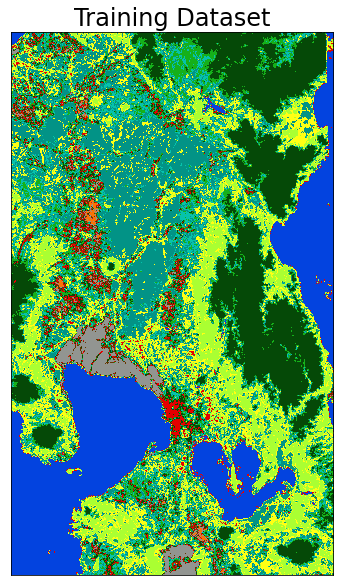

In [ ]:
class LULC(enum.Enum):
    ANNUAL_CROP     = (0,  'Annual Crop',   'xkcd:orange')
    AQUACULTURE     = (1,  'Aquaculture',   'xkcd:grey')
    BARREN_LAND     = (2,  'Barren land',   'xkcd:brown')
    DENSE_URBAN     = (3,  'Dense Urban',   'xkcd:red')
    FOREST          = (4,  'Forest',        'xkcd:darkgreen')
    GRASSLAND       = (5,  'Grassland',     'xkcd:green')
    MANGROVE        = (6,  'Mangrove',      'xkcd:turquoise')
    PADDY_RICE      = (7,  'Paddy Rice',    'xkcd:Teal')
    PERMANENT_CROP  = (8,  'Permanent Crop','xkcd:yellow')
    SHRUBLAND       = (9,  'Shrubland',     'xkcd:lime')
    SPARSE_URBAN    = (10, 'Sparse Urban',  'xkcd:red')
    WATER           = (11, 'Water',         'xkcd:blue')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

plt.figure(figsize=(20,10))
plt.imshow(tiff, cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Training Dataset', fontsize=24)
plt.show()

In [ ]:
import os 
import rasterio

driver = raster.GetDriver()
outputPath = '/content/drive/MyDrive/Colab Notebooks'

with rasterio.open(raster_path) as src:
  b1 = src.read(1)

kwargs = src.meta
kwargs.update(dtype=rasterio.float32, count=1)
with rasterio.open (outputPath+'/'+'prediction_Landcover2020'+'.tiff', 'w', **kwargs) as dst:
  dst.write_band(1, tiff.astype(rasterio.float32))

ValueError: ignored

In [ ]:
## Landcover pallette
igbpPalette = [
  'ff7f00', # annualCrop
  '79a191', # aquaculture
  'a5a5a5', # barren land
  'd7191c', # dense urban
  '228b22', # forest
  '55d400', # grass land
  '778b22', # mangrove
  '05bd9b', # paddy rice
  'f0c420', # permanent crop
  'b6ff05', # shrubland
  'd718c1', # sparse urban
  '1f78b4'  # water
]

In [ ]:
my_map = folium.Map(location=[14.65, 120.675], zoom_start=9)

# Add custom basemaps
basemaps['Google Terrain'].add_to(my_map)

# Add the elevation model to the map object.
my_map.add_ee_layer(classified.clip(boundary), {'palette': igbpPalette, 'min': 0, 'max': 11}, 'Classified Image')
my_map.add_ee_layer(Point_1.geometry(), {}, 'Point 1')
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)